## DataSet Import

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [4]:
df_train = pd.read_csv('angles_train_slim.csv')
df_val = pd.read_csv('angles_val_slim.csv')
df_test = pd.read_csv('angles_test_slim.csv')

In [5]:
df_train.shape, df_val.shape, df_test.shape

((48063, 14), (17253, 14), (4203, 14))

In [6]:
distinct_exercises = [
    'deadlift',
    'hammer curl',
    'lateral raise',
    'plank',
    'push-up',
    'russian twist',
    'squat',
]

df_train = df_train[df_train['label'].isin(distinct_exercises)]
df_val = df_val[df_val['label'].isin(distinct_exercises)]
df_test = df_test[df_test['label'].isin(distinct_exercises)]

In [7]:
df_train.shape, df_val.shape, df_test.shape

((17350, 14), (6012, 14), (1472, 14))

In [5]:
df_test.head()

,left_elbow_angle,right_elbow_angle,left_knee_angle,right_knee_angle,left_hip_angle,right_hip_angle,shoulder_angle,hip_angle,torso_angle,right_hand_to_right_hip_dist,left_hand_to_left_hip_dist,feet_distance,video_id,label
0,138.947488,162.766969,124.553949,140.638801,178.712822,116.500696,46.357860,86.248724,178.712822,0.190009,0.261295,0.265007,bench press_2.mp4,bench press
1,114.110429,173.777749,134.378650,177.752328,167.266094,121.707414,115.111259,178.211263,167.266094,0.245936,0.253181,0.332507,bench press_2.mp4,bench press
2,116.956639,135.088549,174.451099,173.850235,178.770829,124.467218,79.342226,133.746391,178.770829,0.211990,0.233763,0.267604,bench press_2.mp4,bench press
3,118.187781,155.252207,159.870824,162.802470,167.184352,171.523138,113.925959,151.772032,167.184352,0.228906,0.247527,0.041285,bench press_2.mp4,bench press
4,104.415092,133.780747,165.241940,161.604311,173.440980,169.318830,89.722070,132.918508,173.440980,0.209976,0.224168,0.073099,bench press_2.mp4,bench press


## Preprocessing

In [8]:
def clean_data(df):
    numeric_cols = df.select_dtypes(include=np.number).columns

    df[numeric_cols] = df.groupby('video_id')[numeric_cols].transform(
        lambda x: x.interpolate(method='linear', limit_direction='both')
    )

    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    return df

In [9]:
def remove_zero_frames(df):
    angle_cols = [col for col in df.columns if col not in ["label", "video_id", "Unnamed: 0"]]
    return df[(df[angle_cols].sum(axis=1) != 0)]

In [10]:
def clip_outliers_by_exercise(df):
    processed_groups = []
    grouped = df.groupby('label')

    for _, group in grouped:
        cols_to_process = group.select_dtypes(include=np.number).columns
        modified_group = group.copy()

        for column in cols_to_process:
            Q1 = modified_group[column].quantile(0.25)
            Q3 = modified_group[column].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            modified_group[column] = modified_group[column].clip(lower=lower_bound, upper=upper_bound)

        processed_groups.append(modified_group)

    return pd.concat(processed_groups, ignore_index=True)

In [11]:
def preprocess_dataset(df):
    df = clean_data(df)

    df = remove_zero_frames(df)

    df = clip_outliers_by_exercise(df)

    return df

In [12]:
df_train = preprocess_dataset(df_train)
df_val = preprocess_dataset(df_val)
df_test = preprocess_dataset(df_test)

/tmp/ipython-input-3759811462.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/tmp/ipython-input-3759811462.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipython-input-3759811462.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/tmp/ipython-input-3759811462.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipython-input-3759811462.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffil

In [13]:
df_train.shape, df_val.shape, df_test.shape

((17350, 14), (6012, 14), (1472, 14))

## Plotting

In [14]:
from matplotlib import pyplot as plt
import seaborn as sns

In [15]:
exercises = df_train['label'].unique()

In [16]:
angle_columns = [col for col in df_train.columns if col != ['label','video_id']]

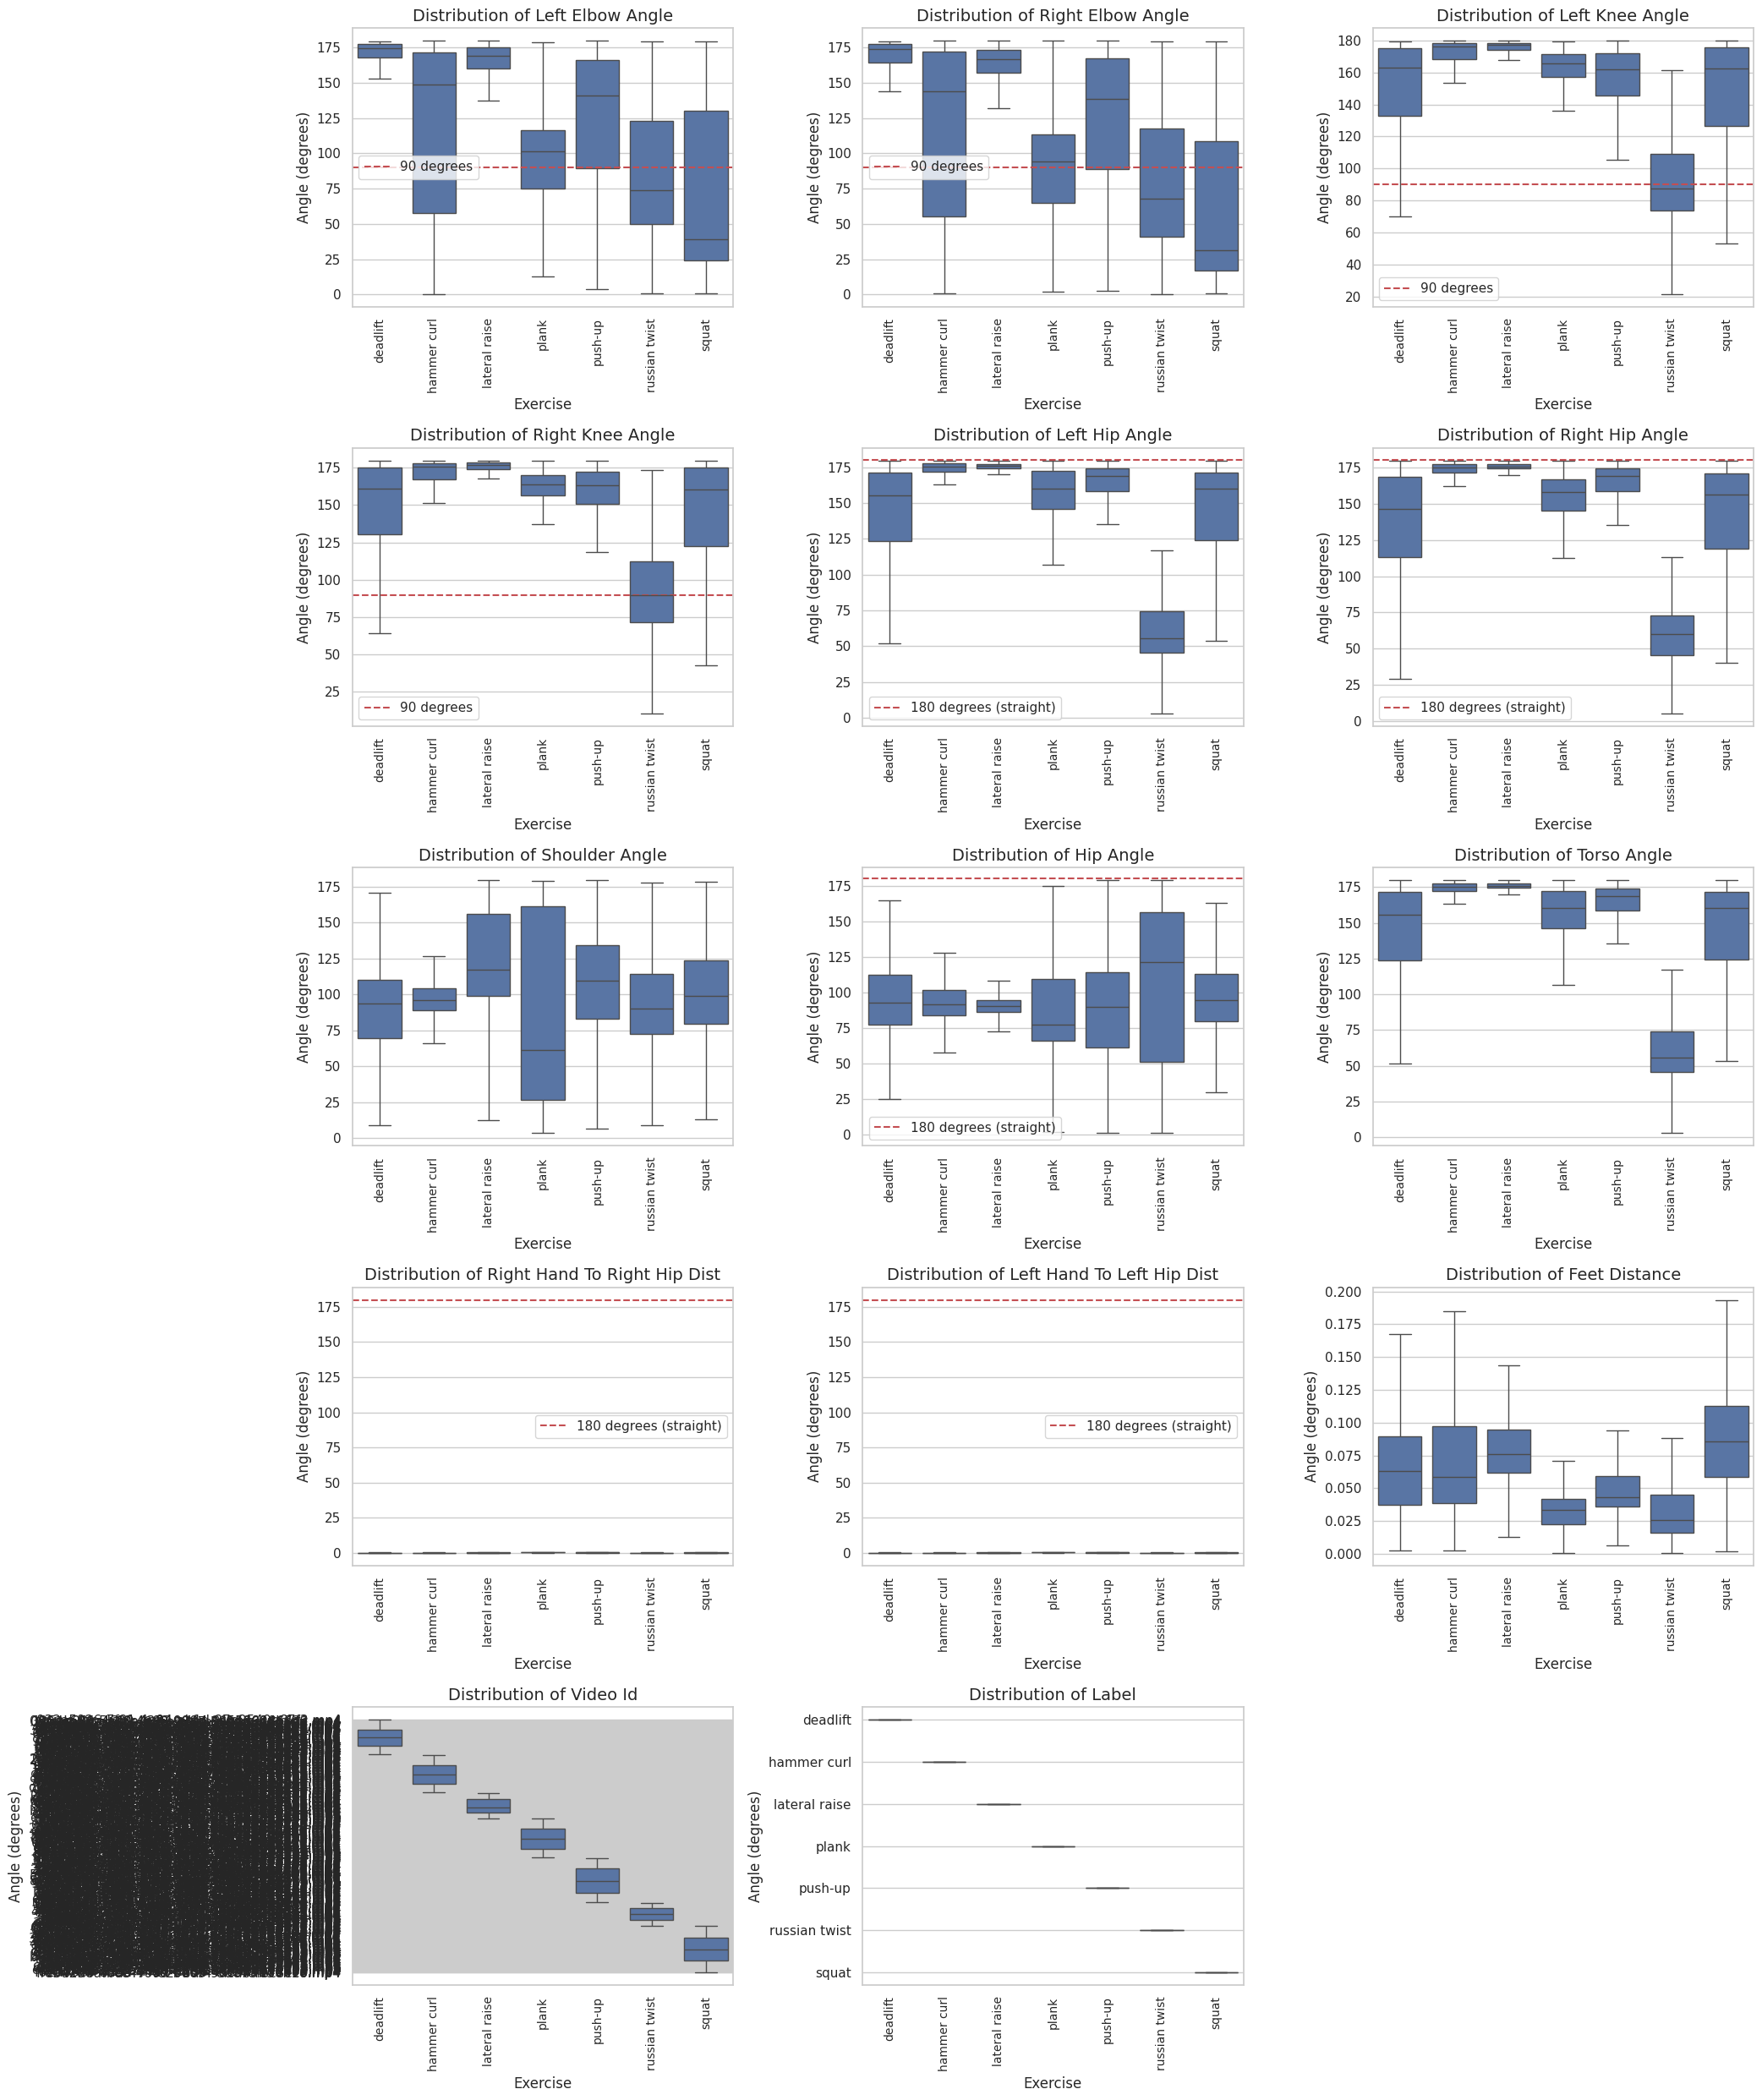

In [17]:
sns.set(style="whitegrid")

num_angles = len(angle_columns)
cols = 3
rows = (num_angles + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(7 * cols, 5 * rows))
axes = axes.flatten() if rows > 1 or cols > 1 else [axes]

for i, angle_name in enumerate(angle_columns):
    ax = axes[i]

    sns.boxplot(x='label', y=angle_name, data=df_train, ax=ax)

    ax.set_title(f'Distribution of {angle_name.replace("_", " ").title()}', fontsize=14)
    ax.set_xlabel('Exercise', fontsize=12)
    ax.set_ylabel('Angle (degrees)', fontsize=12)
    ax.tick_params(axis='x', rotation=90, labelsize=10)

    if "elbow" in angle_name or "knee" in angle_name:
         ax.axhline(y=90, color='r', linestyle='--', linewidth=1.5, label='90 degrees')
         ax.legend()
    elif "hip" in angle_name:
        ax.axhline(y=180, color='r', linestyle='--', linewidth=1.5, label='180 degrees (straight)')
        ax.legend()

for i in range(len(angle_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


## Reshaping Data

In [18]:
seq_length = 25
overlap= 13

In [19]:
def create_sequences_by_video(df, seq_length, overlap):
    X, y = [], []
    grouped_by_video = df.groupby(['label', 'video_id'])

    for (label, video_id), group in tqdm(grouped_by_video, desc="Creating Sequences"):
        data = group.drop(['label', 'video_id'], axis=1).values
        if len(data) < seq_length:
            continue

        for i in range(0, len(data) - seq_length + 1, seq_length - overlap):
            X.append(data[i:i + seq_length])
            y.append(label)

    X = np.array(X)
    y = np.array(y)
    return X, y

In [20]:
X_train, y_train_str = create_sequences_by_video(df_train, seq_length, overlap)
X_val, y_val_str = create_sequences_by_video(df_val, seq_length, overlap)
X_test, y_test_str = create_sequences_by_video(df_test, seq_length, overlap)

Creating Sequences: 100%|██████████| 15/15 [00:00<00:00, 1572.51it/s]


In [21]:
X_train.shape, X_val.shape, X_test.shape

((793, 25, 12), (319, 25, 12), (99, 25, 12))

## Augmentation

In [22]:
def augment_sequences(X, y, n_augments=1):
    X_augmented_list = [X]
    y_augmented_list = [y]

    for _ in range(n_augments):
        X_aug = X.copy()

        # Jittering (Adding Gaussian Noise)
        noise = np.random.normal(0, 0.05, X_aug.shape)
        X_aug += noise

        # Scaling
        scale_factor = np.random.uniform(0.9, 1.1, size=(X_aug.shape[0], 1, 1))
        X_aug *= scale_factor

        X_augmented_list.append(X_aug)
        y_augmented_list.append(y)

    X_augmented = np.concatenate(X_augmented_list, axis=0)
    y_augmented = np.concatenate(y_augmented_list, axis=0)

    return X_augmented, y_augmented


In [23]:
X_train_aug, y_train_aug_str = augment_sequences(X_train, y_train_str, n_augments=2)

In [24]:
X_train_aug.shape

(2379, 25, 12)

### Scaling Data

In [25]:
from sklearn.preprocessing import StandardScaler
import joblib

In [26]:
features = [col for col in df_train.columns if col not in ['label', 'video_id']]

In [27]:
X_train_reshaped = X_train_aug.reshape(-1, X_train_aug.shape[-1])
X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

In [28]:
scaler = StandardScaler()
scaler.fit(X_train_reshaped)

X_train_scaled = scaler.transform(X_train_reshaped)
X_val_scaled = scaler.transform(X_val_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

X_train_final = X_train_scaled.reshape(X_train_aug.shape)
X_val_final = X_val_scaled.reshape(X_val.shape)
X_test_final = X_test_scaled.reshape(X_test.shape)

joblib.dump(scaler, 'real_time_scaler.pkl')

['real_time_scaler.pkl']

In [29]:
print(f"Final X_train shape for GRU: {X_train_final.shape}")
print(f"Final X_val shape for GRU: {X_val_final.shape}")
print(f"Final X_test shape for GRU: {X_test_final.shape}")

Final X_train shape for GRU: (2379, 25, 12)
Final X_val shape for GRU: (319, 25, 12)
Final X_test shape for GRU: (99, 25, 12)


## Encoding

In [30]:
from sklearn.preprocessing import LabelEncoder

In [31]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_aug_str)
y_val_encoded = label_encoder.transform(y_val_str)
y_test_encoded = label_encoder.transform(y_test_str)

joblib.dump(label_encoder, 'label_encoder.pkl')


['label_encoder.pkl']

# GRU BUILDING

In [190]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [191]:
num_features = X_train_aug.shape[2]
num_classes = len(np.unique(y_train_encoded))

# gru_model.h5
# model = Sequential()
# model.add(tf.keras.Input(shape=(seq_length, num_features)))
# model.add(GRU(64, return_sequences=True))
# model.add(Dropout(0.3))
# model.add(GRU(32))
# model.add(Dropout(0.3))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(num_classes, activation='softmax'))

# gru_model_2.h5
model = Sequential()
model.add(tf.keras.Input(shape=(seq_length, num_features)))
model.add(Bidirectional(GRU(64, return_sequences=True)))
model.add(BatchNormalization())  # Added Batch Normalization
model.add(Dropout(0.3))
model.add(GRU(32))
model.add(BatchNormalization())  # Added Batch Normalization
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())  # Added Batch Normalization
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())  # Added Batch Normalization
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

In [192]:
from sklearn.utils.class_weight import compute_class_weight

In [193]:
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_str),
    y=y_train_str
)

In [194]:
class_weight_dict = dict(enumerate(class_weights))

In [195]:
print("Calculated Class Weights:")
print(class_weight_dict)

Calculated Class Weights:
{0: np.float64(1.6183673469387756), 1: np.float64(0.7812807881773399), 2: np.float64(1.6183673469387756), 3: np.float64(0.6663865546218487), 4: np.float64(1.0025284450063212), 5: np.float64(1.5308880308880308), 6: np.float64(0.750236518448439)}


In [196]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [197]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

In [198]:
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_7 (Bidirectional) │ (None, 25, 128)        │        29,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 25, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_26 (GRU)                    │ (None, 32)             │        15,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,951 (199.03 KB)

 Trainable params: 50,439 (197.03 KB)

 Non-trainable params: 512 (2.00 KB)

In [199]:
epochs = 120
batch_size = 32

In [200]:
history = model.fit(
    X_train_final,
    y_train_encoded,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_final, y_val_encoded),
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

Epoch 1/120
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.1919 - loss: 2.4805 - val_accuracy: 0.2915 - val_loss: 1.7509
Epoch 2/120
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2519 - loss: 2.0811 - val_accuracy: 0.4451 - val_loss: 1.5577
Epoch 3/120
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3093 - loss: 1.8863 - val_accuracy: 0.5329 - val_loss: 1.3436
Epoch 4/120
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3807 - loss: 1.7015 - val_accuracy: 0.5956 - val_loss: 1.1916
Epoch 5/120
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4258 - loss: 1.5783 - val_accuracy: 0.6332 - val_loss: 1.0992
Epoch 6/120
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.4219 - loss: 1.5283 - val_accuracy: 0.6458 - val_loss: 1.0224
Epoch 7/120
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4313 - loss: 1.5062 - val_accuracy: 0.6771 - val_loss: 0.9551
Epoch 8/120
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4849 - loss: 1.4082 - val_accuracy: 0.

## Evaluating Model

In [43]:
print("Evaluating on test data...")
loss, accuracy = model.evaluate(X_test_final, y_test_encoded)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Evaluating on test data...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3432 - loss: 3.0077 
Test Loss: 2.4058
Test Accuracy: 0.4646


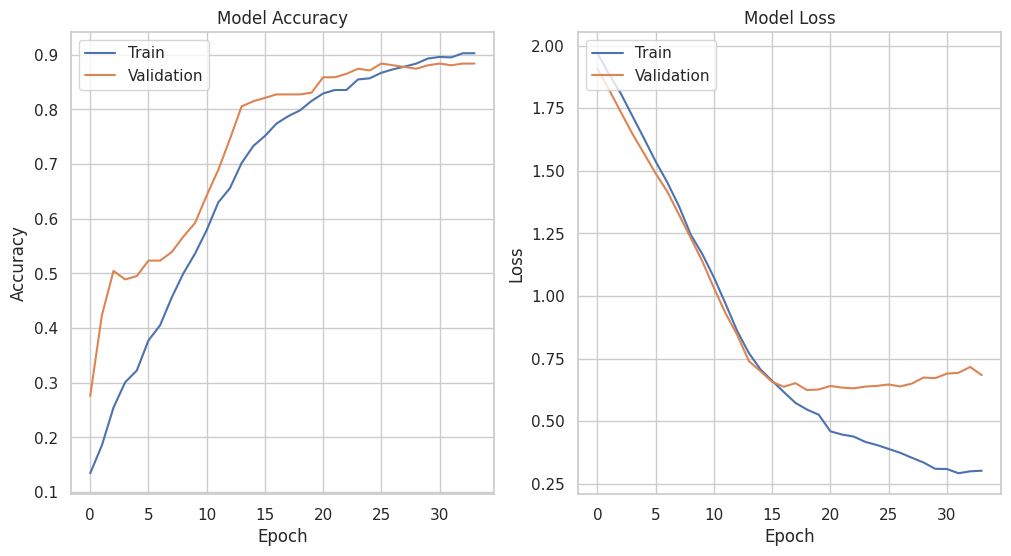

In [44]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [202]:
#second model
print("Evaluating on test data...")
loss, accuracy = model.evaluate(X_test_final, y_test_encoded)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Evaluating on test data...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4241 - loss: 2.7180
Test Loss: 2.3666
Test Accuracy: 0.4848


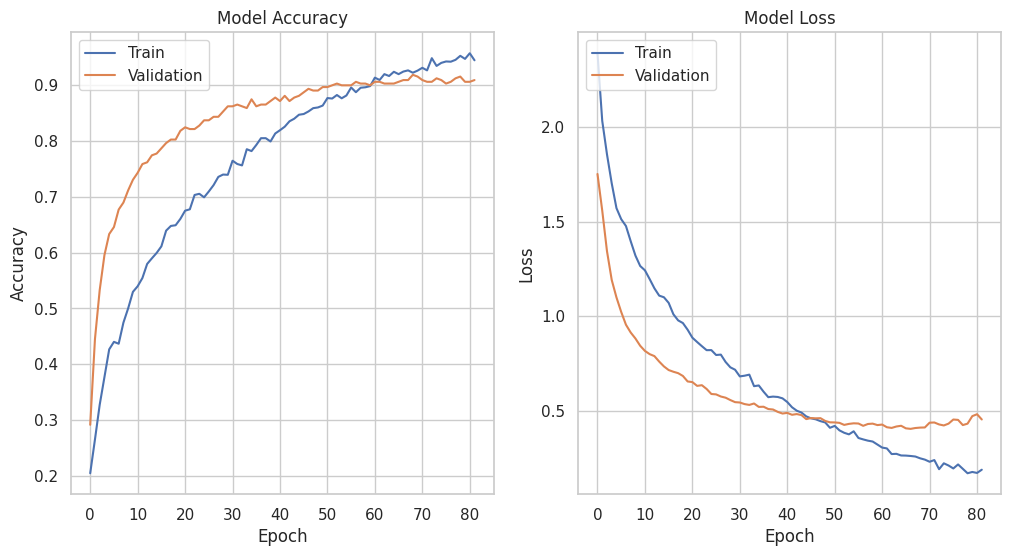

In [201]:
#second model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [45]:
model.save('gru_model.h5')

In [203]:
model.save('gru_model_2.h5')

In [46]:
import json
label_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}

# Save the label mapping to a JSON file
with open('encoded_labels.json', 'w') as f:
    json.dump(label_mapping, f)

In [47]:
label_mapping

{0: np.str_('deadlift'),
 1: np.str_('hammer curl'),
 2: np.str_('lateral raise'),
 3: np.str_('plank'),
 4: np.str_('push-up'),
 5: np.str_('russian twist'),
 6: np.str_('squat')}

## Using ML APPROACH

1.  Random Forest Classifier
2.  Light GBM



In [60]:
X_train_flat = X_train_final.reshape(X_train_final.shape[0], -1)
X_val_flat = X_val_final.reshape(X_val_final.shape[0], -1)
X_test_flat = X_test_final.reshape(X_test_final.shape[0], -1)

print(f"Flattened training data shape: {X_train_flat.shape}")
print(f"Flattened validation data shape: {X_val_flat.shape}")
print(f"Flattened test data shape: {X_test_flat.shape}")

Flattened training data shape: (2379, 300)
Flattened validation data shape: (319, 300)
Flattened test data shape: (99, 300)


In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

### Using Class Balancing

In [51]:
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
class_weight_dict = dict(enumerate(class_weights))

In [61]:
rfc = RandomForestClassifier(
    n_estimators=100,
    class_weight=class_weight_dict,
    random_state=42,
    n_jobs=-1 #
)

print("Training Random Forest Classifier...")
rfc.fit(X_train_flat, y_train_encoded)

Training Random Forest Classifier...


RandomForestClassifier(class_weight={0: np.float64(1.6183673469387756),
                                     1: np.float64(0.7812807881773399),
                                     2: np.float64(1.6183673469387756),
                                     3: np.float64(0.6663865546218487),
                                     4: np.float64(1.0025284450063212),
                                     5: np.float64(1.5308880308880308),
                                     6: np.float64(0.750236518448439)},
                       n_jobs=-1, random_state=42)

In [64]:
val_preds = rfc.predict(X_val_flat)
val_accuracy = accuracy_score(y_val_encoded, val_preds)
print(f"\nValidation Accuracy: {val_accuracy:.4f}")


Validation Accuracy: 0.8683


In [65]:
print("\nValidation Classification Report:")
print(classification_report(y_val_encoded, val_preds))


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.33      0.48        33
           1       0.81      0.98      0.89        45
           2       0.96      0.69      0.81        36
           3       0.94      0.92      0.93        51
           4       0.93      1.00      0.96        81
           5       0.95      1.00      0.97        38
           6       0.63      0.89      0.74        35

    accuracy                           0.87       319
   macro avg       0.87      0.83      0.83       319
weighted avg       0.88      0.87      0.86       319



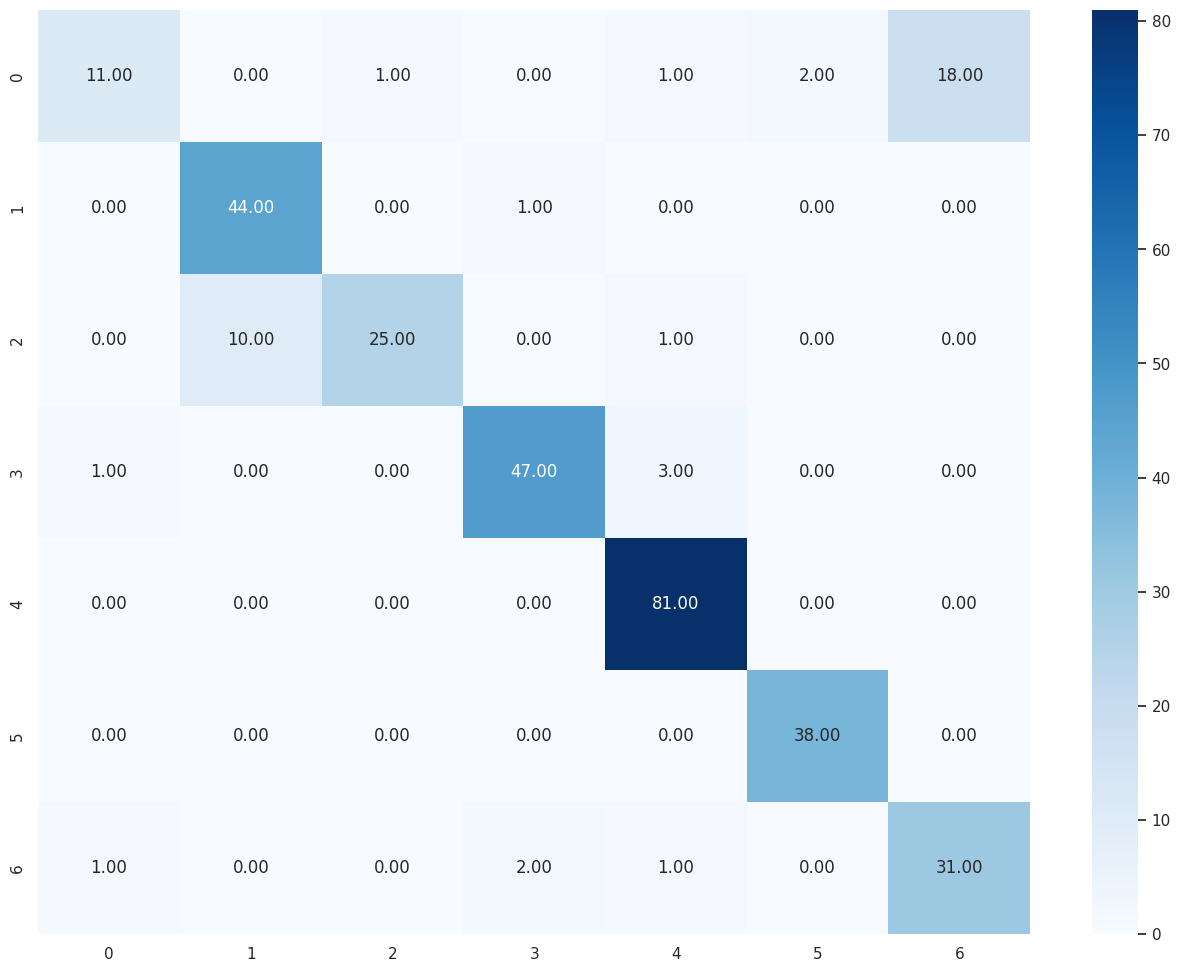

In [66]:
plt.figure(figsize=(16,12))
sns.heatmap(confusion_matrix(y_val_encoded, val_preds), cmap='Blues', annot=True, fmt=".2f")
plt.show()

In [68]:
test_preds = rfc.predict(X_test_flat)
test_accuracy = accuracy_score(y_test_encoded, test_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.3333


## Light GBM

In [69]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [70]:
lgb_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(np.unique(y_train_encoded)),
    n_estimators=100,
    learning_rate=0.1,
    class_weight=class_weight_dict,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print("Training LightGBM Classifier...")
lgb_model.fit(X_train_flat, y_train_encoded)
print("Training complete.")

Training LightGBM Classifier...
Training complete.


In [72]:
val_preds = lgb_model.predict(X_val_flat)
val_accuracy = accuracy_score(y_val_encoded, val_preds)
print(f"\nValidation Accuracy: {val_accuracy:.4f}")
print("Validation Classification Report:")
print(classification_report(y_val_encoded, val_preds))


Validation Accuracy: 0.8652
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.33      0.49        33
           1       0.94      1.00      0.97        45
           2       0.94      0.86      0.90        36
           3       0.92      0.94      0.93        51
           4       0.86      0.96      0.91        81
           5       0.78      1.00      0.87        38
           6       0.74      0.71      0.72        35

    accuracy                           0.87       319
   macro avg       0.87      0.83      0.83       319
weighted avg       0.87      0.87      0.85       319



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


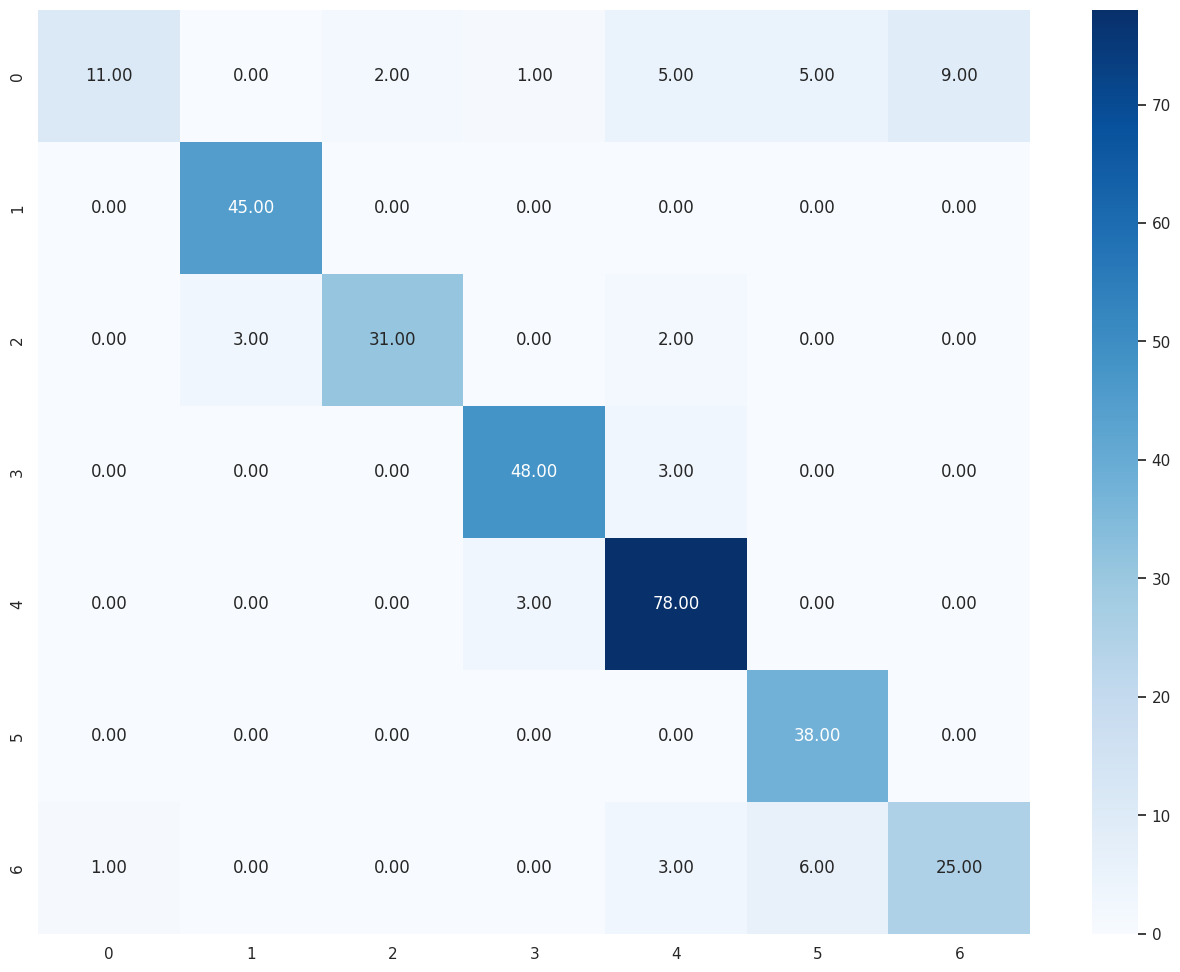

In [74]:
plt.figure(figsize=(16,12))
sns.heatmap(confusion_matrix(y_val_encoded, val_preds), cmap='Blues', annot=True, fmt=".2f")
plt.show()

In [75]:
test_preds = lgb_model.predict(X_test_flat)
test_accuracy = accuracy_score(y_test_encoded, test_preds)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print("Test Classification Report:")
print(classification_report(y_test_encoded, test_preds))


Test Accuracy: 0.3232
Test Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.26      0.39        47
           1       1.00      0.29      0.44         7
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         8
           4       0.45      1.00      0.62        10
           5       0.11      0.44      0.18         9
           6       0.17      0.31      0.22        13

    accuracy                           0.32        99
   macro avg       0.36      0.33      0.27        99
weighted avg       0.53      0.32      0.32        99



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
joblib.dump(lgb_model, 'lgb_model.pkl')

['lgb_model.pkl']

In [76]:
label_mapping

{0: np.str_('deadlift'),
 1: np.str_('hammer curl'),
 2: np.str_('lateral raise'),
 3: np.str_('plank'),
 4: np.str_('push-up'),
 5: np.str_('russian twist'),
 6: np.str_('squat')}

In [77]:
seq_length

25

In [78]:
overlap

13

In [81]:
df_train.columns

Index(['left_elbow_angle', 'right_elbow_angle', 'left_knee_angle',
       'right_knee_angle', 'left_hip_angle', 'right_hip_angle',
       'shoulder_angle', 'hip_angle', 'torso_angle',
       'right_hand_to_right_hip_dist', 'left_hand_to_left_hip_dist',
       'feet_distance', 'video_id', 'label'],
      dtype='object')